In [1]:
# Please visit:
#
# https://download.nkg-mn.com/credo/anomalies/
#
# Pretrained dots_100000.h5 and others can be downloaded from mentioned website.

In [2]:
from align_images_pca import align_image
from PIL import Image
import numpy as np
import glob


TRACKS_SRC = 'hit-images-final2/line'
WORMS_SRC = 'hit-images-final2/worms'


def load_images(src):
    images = []
    files = list(glob.glob("%s/*.png" % src))
    files = sorted(files)
    for image_path in files:
        img = Image.open(image_path)
        img = img.convert('L')
        image = np.asarray(img)
        #image = np.asarray(Image.open(image_path).convert('L'))
        image = align_image(image)
        mask = np.where(image > 25, 1, 0)
        image = mask * image
        image = image.astype(np.float32) / np.max(image)
        image = np.expand_dims(image, 2)
        images.append(image)
    return np.asarray(images), files


tracks_set, tacks_files = load_images(TRACKS_SRC)
worms_set, worms_files = load_images(WORMS_SRC)

In [3]:
def augmentation_mirror(src, files):
    images = []
    files_aug = []
    for i in range(0, len(src)):
        img = src[i]
        images.append(img)
        images.append(np.flip(img))
        files_aug.append(files[i])
        files_aug.append(files[i])
    return np.asarray(images), files_aug


tracks2_set, tacks2_files = augmentation_mirror(tracks_set, tacks_files)
worms2_set, worms2_files = augmentation_mirror(worms_set, worms_files)

In [4]:
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    p = np.random.permutation(df.shape[0])
    n = int(train_percent * len(p))
    m = int(validate_percent * len(p)) + n
    train = p[:n]
    validation = p[n:m]
    test = p[m:]
    return train, validation, test


tracks2_train, tracks2_validate, tracks2_test = train_validate_test_split(tracks2_set)
worms2_train, worms2_validate, worms2_test = train_validate_test_split(worms2_set)

320
0
128
18496
0
256
0
230416
244800
0
36928
0
256
18464
0
128
289
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 60, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 30, 30, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 15, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 15, 15, 64)        0 

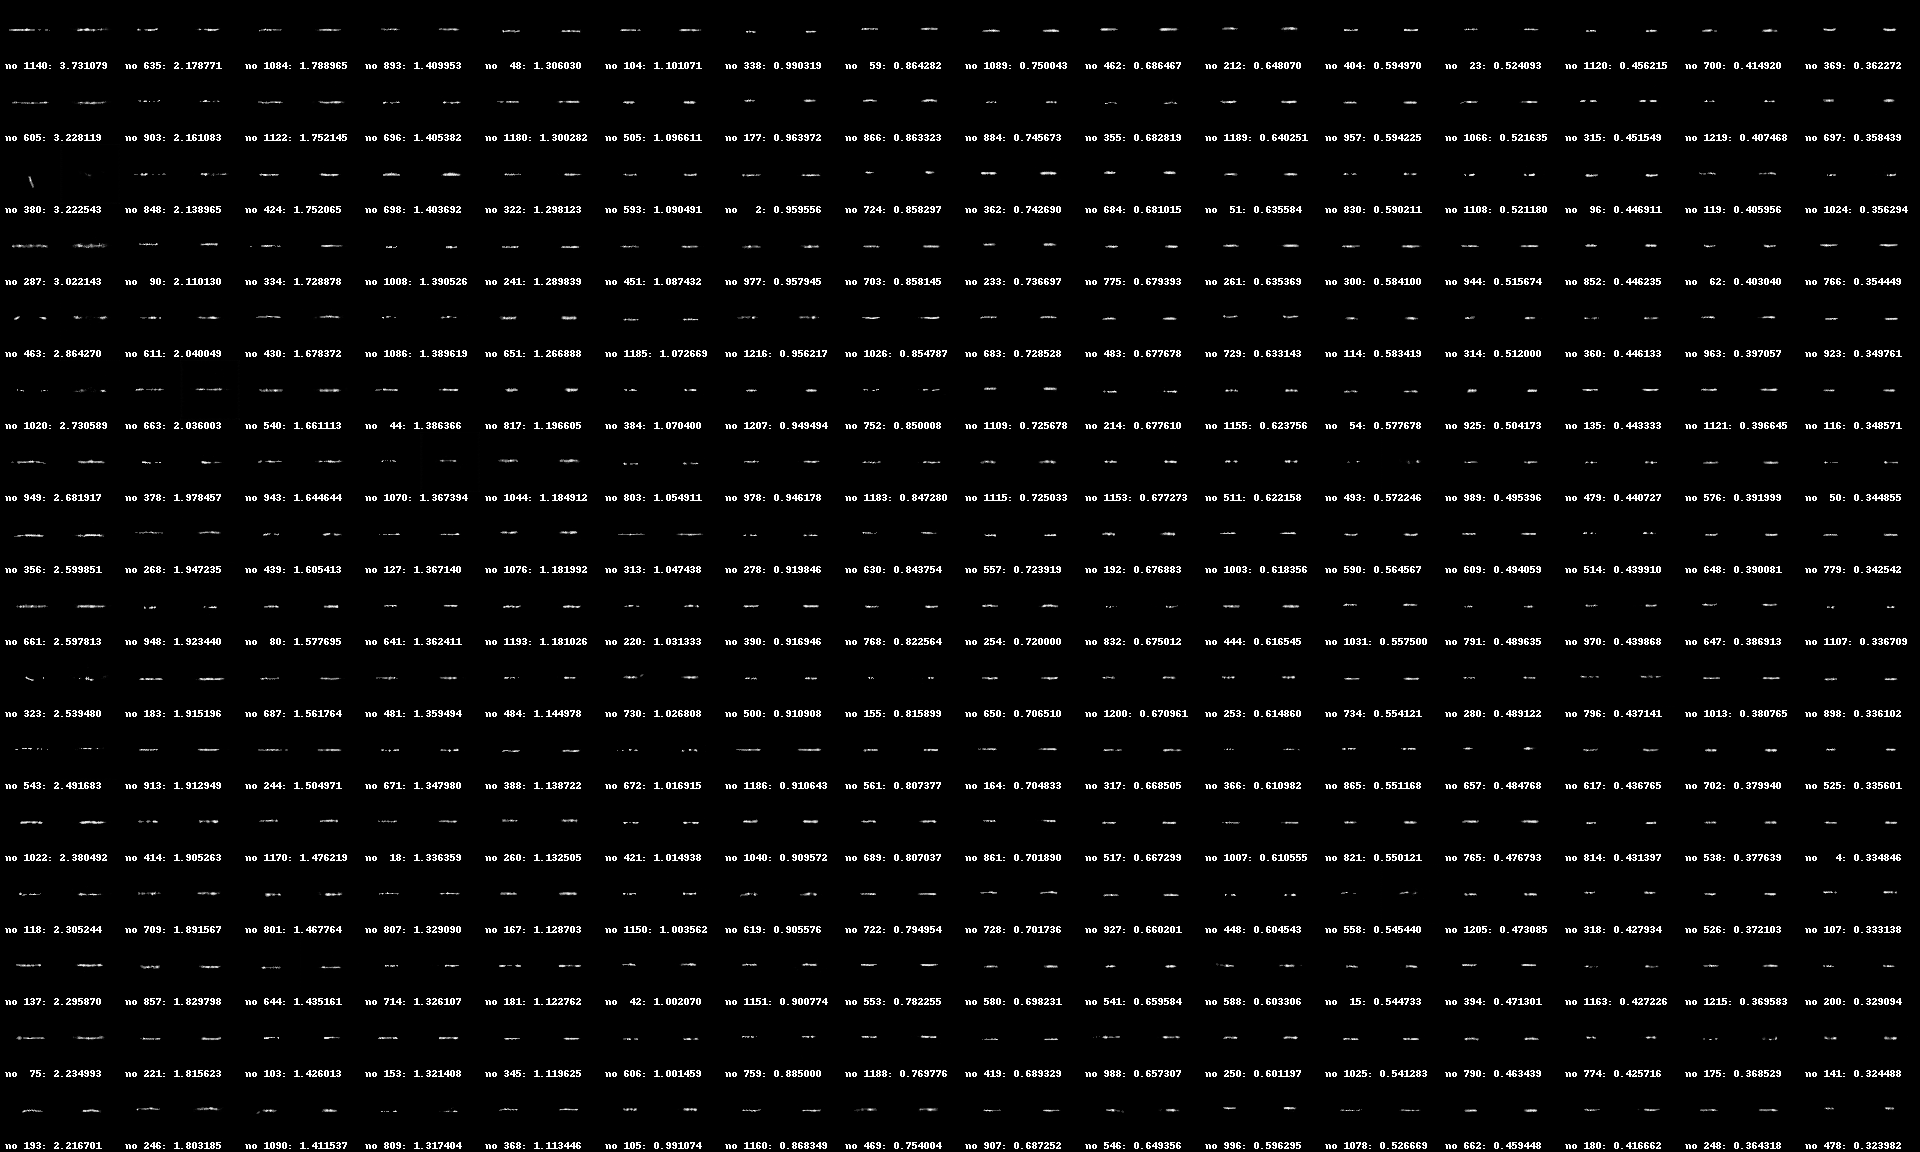

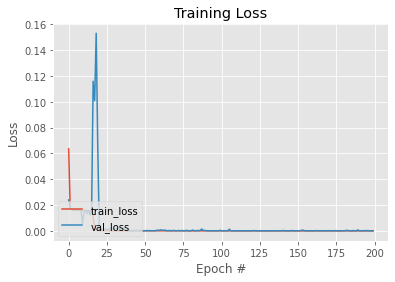

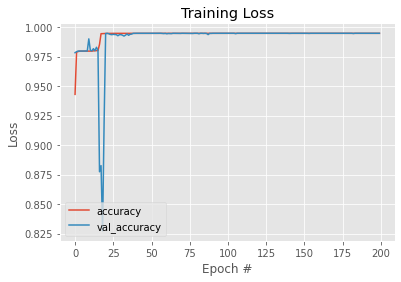

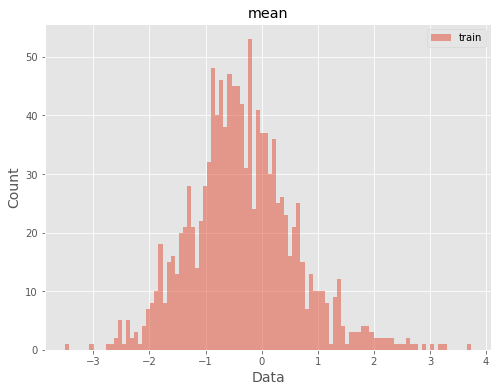

In [5]:
from commons import *
from dataset_loader import load_from_file
from IPython.display import display
import matplotlib.pyplot as plt
import cv2

#DOTS_DST = 'cache/dots_100000.pickle'
#ARTIFACTS_DST = 'cache/artifacts_100000.pickle'

#DOTS_AC = 'cache/dots_100000.h5'
TRACKS_AC = 'cache/th_100000.h5'
#WORMS_AC = 'cache/worms_100000.h5'
#ARTIFACTS_AC = 'cache/artifacts_100000.h5'

def train_and_test(train_set, validation_set, fn):
    autoencoder = original_autoencoder()
    autoencoder = train_or_cache(train_set, autoencoder, fn, validation_set=validation_set, force_train=True)

    for df_func, df_name in zip(
            [dm_func_mean],
            ['mean']
    ):
        for img_set, set_names in zip([validation_set], ['train']):
            decoded = autoencoder.predict(img_set)

            vis, errors = visualize_predictions(decoded, img_set, df_func, False, 16)
            img_path = fn.replace('.h5', '-vis.png')
            hist_path = fn.replace('.h5', '-hist.png')
            cv2.imwrite(img_path, vis)
            display(Image.open(img_path))
            if len(img_set) > 256:
                vis, errors = visualize_predictions(decoded, img_set, df_func, False)
                img_path = fn.replace('.h5', '-vis_full.png')
                cv2.imwrite(img_path, vis)

            plt.figure(figsize=(8,6))
            plt.hist(errors, bins=100, alpha=0.5, label=set_names)
            plt.xlabel("Data", size=14)
            plt.ylabel("Count", size=14)
            plt.title(df_name)
            plt.legend(loc='upper right')
            plt.savefig(hist_path)


train_and_test(tracks2_set[tracks2_train], tracks2_set[tracks2_validate], TRACKS_AC)

In [13]:
from keras.models import load_model

def encoder_embedding(model_file, test_set):
    encoder = load_model(model_file.replace('.h5', '-encoder.h5'))
    embedding = encoder.predict(test_set)
    #with_c = np.vstack([v, np.ones(v.shape) * c])
    #transposed = with_c.transpose()
    return embedding

In [23]:
def dbscan(embedding, t_files, eps):
    img_count = len(embedding)
    threshold = 1
    p = 16

    #for a in range(emb_array.shape[0]):
    #    emb_array[a] = emb_array[a] / w

    #emb_array_copy = np.copy(emb_array[0:img_count, 3:50])
    emb_array_copy = np.copy(embedding[0:img_count, 0:p])


    from sklearn.cluster import DBSCAN
    from sklearn import metrics
    from sklearn.datasets import make_blobs
    from sklearn.preprocessing import StandardScaler

    db = DBSCAN(min_samples=5, eps=eps).fit(emb_array_copy)
    #core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    #core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    import matplotlib.pyplot as plt

    # Black removed and is used for noise instead.
    """
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = labels == k

        xy = emb_array_copy[class_member_mask & core_samples_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=14,
        )

        xy = emb_array_copy[class_member_mask & ~core_samples_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=6,
        )
    """
    result = np.where(labels == -1)
    my_ids = result[0]
    print(labels)
    print(my_ids)
    print(len(my_ids))


    import matplotlib.pyplot as plt


    fig = plt.figure(figsize=(32, 32))
    columns = 5
    rows = int(len(my_ids) / 5) + 1

    for aaa in range(len(my_ids)):
        #img_help = cv2.imread('d:\\dane\\credo\\png\\' + all_files_names[my_ids[aaa]])
        img_help = cv2.imread(t_files[my_ids[aaa]])
        print(t_files[my_ids[aaa]])

        aaa1 = aaa + 1
        xxxxx = (aaa % 5) + 1
        r = fig.add_subplot(rows, columns, aaa1)
        r.axis("off")
        plt.imshow(img_help)
        #cv2.imshow(str(aaa), img_help)
        #print(all_files_names[my_ids[0]])

    plt.show()


[0 0 0 ... 0 0 0]
[   5  166  179  211  219  256  386  408  556  584  629  699  722  733
  778  848  926  953 1053 1075 1135 1170 1219]
23
hit-images-final2/line\11854979.png
hit-images-final2/line\23300748.png
hit-images-final2/line\22500203.png
hit-images-final2/line\23478695.png
hit-images-final2/line\15258914.png
hit-images-final2/line\24193026.png
hit-images-final2/line\22039751.png
hit-images-final2/line\23072383.png
hit-images-final2/line\23424169.png
hit-images-final2/line\11858430.png
hit-images-final2/line\23447798.png
hit-images-final2/line\11813671.png
hit-images-final2/line\13892698.png
hit-images-final2/line\22911647.png
hit-images-final2/line\24274103.png
hit-images-final2/line\23375637.png
hit-images-final2/line\24579151.png
hit-images-final2/line\11834173.png
hit-images-final2/line\13873250.png
hit-images-final2/line\16626396.png
hit-images-final2/line\22391783.png
hit-images-final2/line\11802037.png
hit-images-final2/line\23740643.png


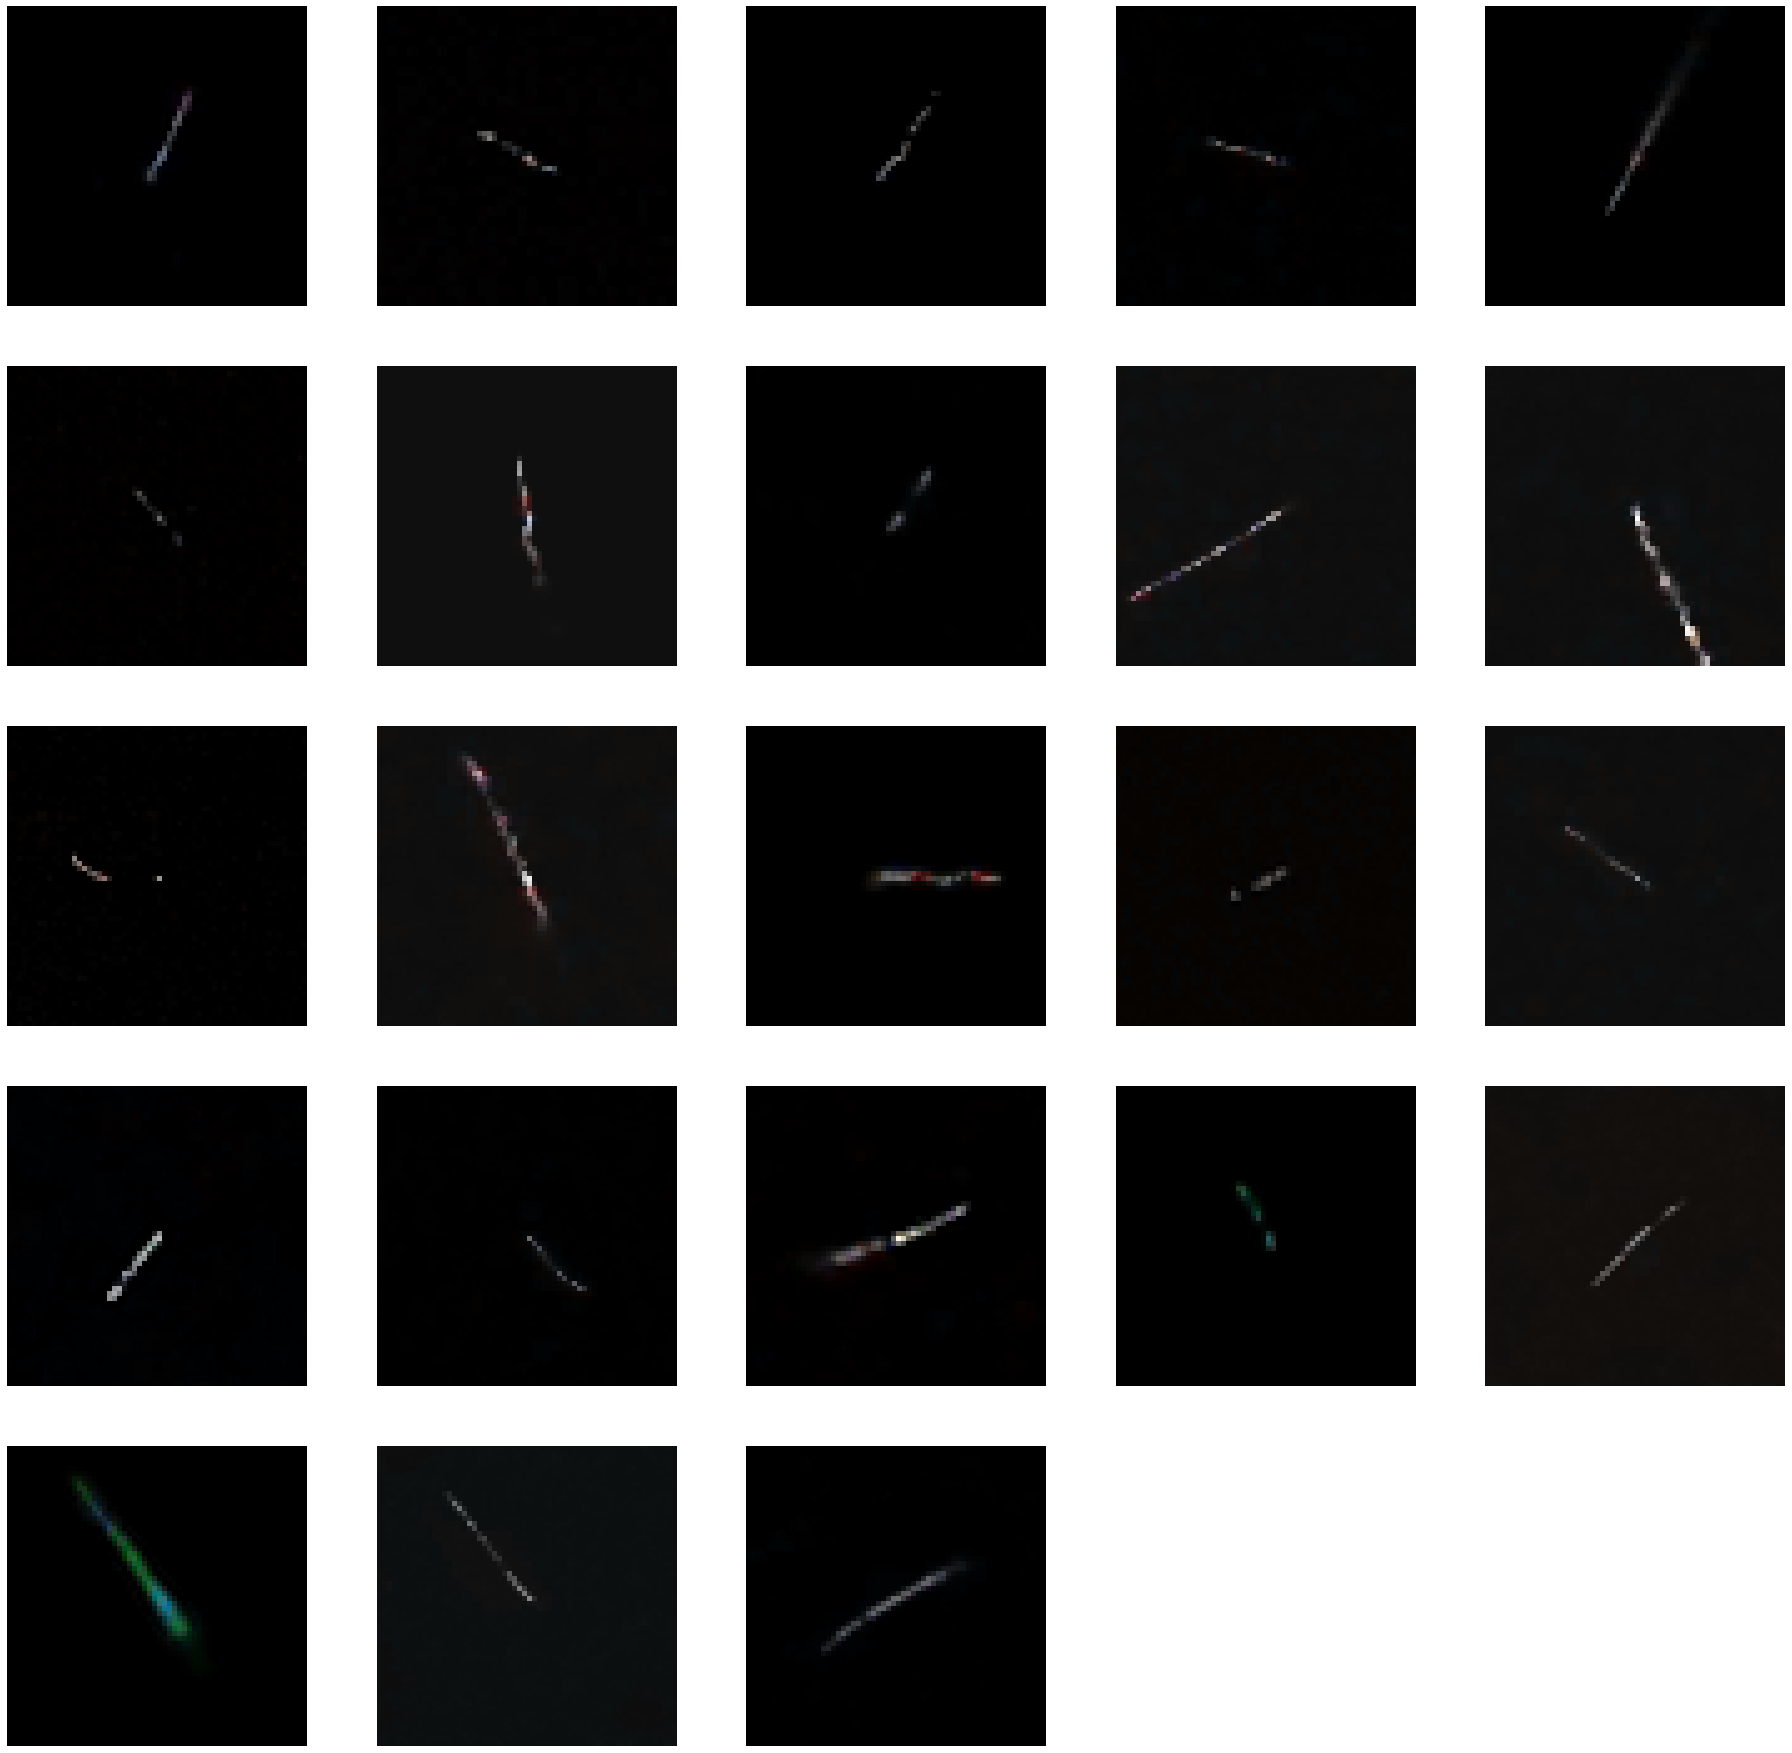

In [24]:
tracks_embedding = encoder_embedding(TRACKS_AC, tracks2_set[tracks2_test])
tracks_t_files = np.asarray(tacks2_files)[tracks2_test]
dbscan(tracks_embedding, tracks_t_files, 120)

[ 0  0  0 ... -1  0  0]
[ 926  953 1219 1227 1243 1261 1263 1275 1277 1279 1287 1299 1322 1333
 1342 1353 1366 1368 1370 1376 1379 1390 1400 1422]
24
hit-images-final2/line\24579151.png
hit-images-final2/line\11834173.png
hit-images-final2/line\23740643.png
hit-images-final2/worms\11823391.png
hit-images-final2/worms\22033316.png
hit-images-final2/worms\22390923.png
hit-images-final2/worms\22380130.png
hit-images-final2/worms\22204424.png
hit-images-final2/worms\22326858.png
hit-images-final2/worms\21972702.png
hit-images-final2/worms\22030411.png
hit-images-final2/worms\22438037.png
hit-images-final2/worms\22054590.png
hit-images-final2/worms\22008402.png
hit-images-final2/worms\22264532.png
hit-images-final2/worms\11823281.png
hit-images-final2/worms\22110467.png
hit-images-final2/worms\22250688.png
hit-images-final2/worms\22343771.png
hit-images-final2/worms\22250688.png
hit-images-final2/worms\11823281.png
hit-images-final2/worms\22438955.png
hit-images-final2/worms\22437786.png
hi

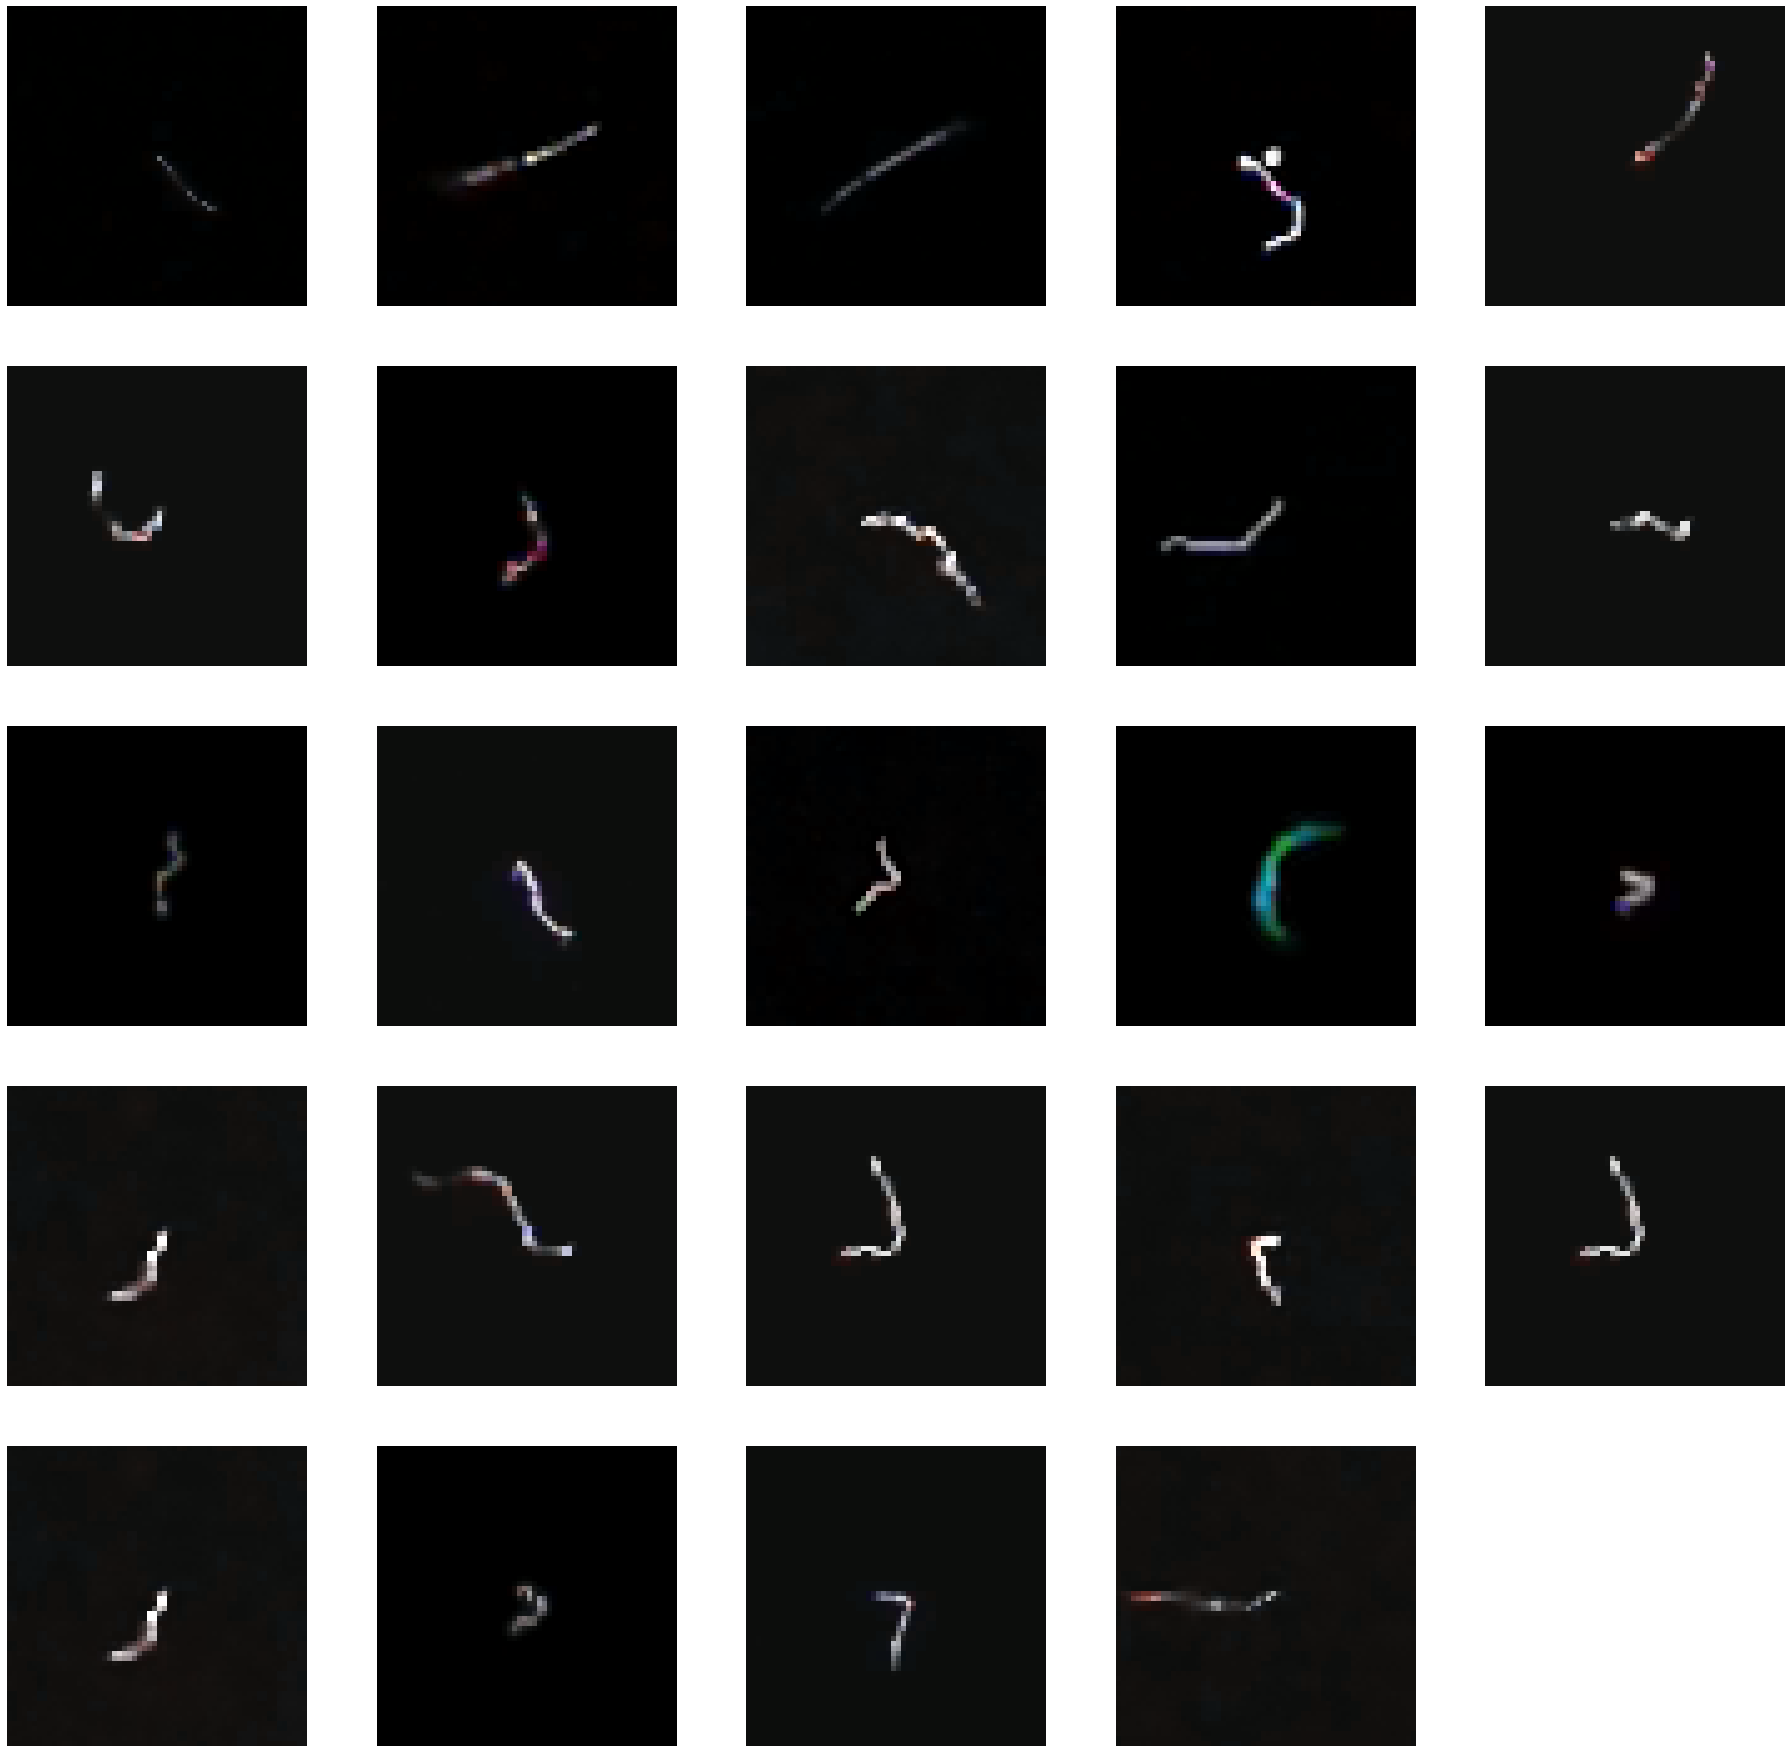

In [25]:
worms_embedding = encoder_embedding(TRACKS_AC, worms2_set[worms2_test])
worms_t_files = np.asarray(worms2_files)[worms2_test]

embedding = np.vstack([tracks_embedding, worms_embedding])
t_files = np.hstack([tracks_t_files, worms_t_files])

dbscan(embedding, t_files, 140)

[ 0  0  0 ...  0  0 -1]
[1219 1226]
2
hit-images-final2/line\23740643.png
hit-images-final2/me\6044.png


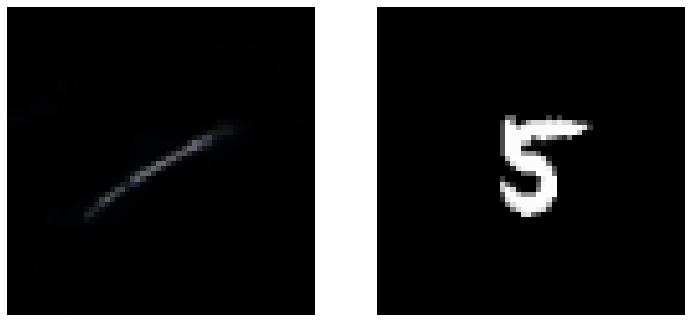

In [31]:
me_set, me_files = load_images('hit-images-final2/me')
me_embedding = encoder_embedding(TRACKS_AC, me_set)
me_files = np.asarray(me_files)

embedding = np.vstack([tracks_embedding, me_embedding])
t_files = np.hstack([tracks_t_files, me_files])

dbscan(embedding, t_files, 150)